In [1]:
import math
import os
import time
import numpy as np
import mxnet as mx
import utils
from mxnet import gluon, autograd
from mxnet.gluon import nn, rnn
from mxnet import ndarray as nd
from mxnet.contrib import text
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim 

import nltk
nltk.download('punkt')

/Users/dawei/anaconda/envs/gluon/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


[nltk_data] Downloading package punkt to /Users/dawei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
#  hyper-parameters 
model_names = ['gru', 'lstm', 'rnn_relu', 'rnn_tanh']
model_name = model_names[0]

embed_dim = 300
max_length = 30
batch_size = 32
# data_related parameters


hidden_dim = 100
num_layers = 1
num_outputs = 5
dropout_rate = 0.5
#  model parameters

lr = 0.02
clipping_norm = 10
epochs = 40
wd = 5e-4
lr_period = 10
lr_decay = 0.1
epoch_period = 10
# optimization parameters

ctx = utils.try_gpu()

In [3]:
class Dictionary(object):
    def __init__(self):
        self.word_to_idx = {}
        self.idx_to_word = []

    def add_word(self, word):
        if word not in self.word_to_idx:
            self.idx_to_word.append(word)
            self.word_to_idx[word] = len(self.idx_to_word) - 1
        return self.word_to_idx[word]

    def __len__(self):
        return len(self.idx_to_word)

In [4]:
class Corpus(object):
    """corpus of texts """
    def __init__(self, path, max_length, tokenizer):
        self.dictionary = Dictionary()
        self.tokenizer = tokenizer
        self.train = self.tokenize(path + 'train.txt', max_length)
        self.valid = self.tokenize(path + 'valid.txt', max_length)
        self.test = self.tokenize(path + 'test.txt', max_length)
        
    def tokenize(self, path, max_length):
        assert os.path.exists(path)
        # Add word to dictionary
        with open(path, 'r') as f:
            sentences = 0
            for line in f:
                sentence = self.tokenizer(line)
                sentence += ['<eos>'] # add the eos to the end of sentences
                sentence +=  ['<pad>'] * (max_length - len(sentence))  # add the pading to sentences 
                for word in sentence:
                    self.dictionary.add_word(word)
                sentences += 1 
        
        # Convert all text to NDarray of Index with shape(num_sentences, max_length_sentences)
        with open(path, 'r') as f:
            indices = np.zeros((sentences, max_length), dtype='int32')
            ids = 0
            for line in f:
                sentence = self.tokenizer(line)
                sentence += ['<eos>'] # add the eos to the end of sentences
                sentence +=  ['<pad>'] * (max_length - len(sentence))  # add the eos at the end of sentences
                for i in range(max_length):
                    indices[ids, i] = self.dictionary.word_to_idx[sentence[i]]
                ids += 1
        return mx.nd.array(indices, dtype='int32')

In [5]:
data = "./data/"
corpus = Corpus(data,max_length, word_tokenize)
vocab_size = len(corpus.dictionary)
word_to_idx = corpus.dictionary.word_to_idx
idx_to_word = corpus.dictionary.idx_to_word

In [6]:
# pre-training word embeding
sentences = gensim.models.word2vec.LineSentence(data + 'train.txt')
word2vec_model = gensim.models.Word2Vec(sentences, size=embed_dim, window=5, min_count=1, workers=4)
pre_embeding = nd.random.uniform(-0.25, 0.25, (vocab_size, embed_dim))
for word in idx_to_word:
    if word in word2vec_model.wv.vocab:
        pre_embeding[word_to_idx[word]-1] = word2vec_model.wv[word]

In [7]:
class RNNModel(gluon.Block):
    """RNN modeling"""
    def __init__(self, mode, vocab_size, num_outputs, max_length, embed_dim, hidden_dim,
                 num_layers, dropout=0.5, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        with self.name_scope():
            self.max_length = max_length
            self.hidden_dim = hidden_dim
            self.dropout = nn.Dropout(dropout)
            self.embedding = nn.Embedding(vocab_size, embed_dim,
                                        weight_initializer=mx.init.Uniform(0.1))
            if mode == 'rnn_relu':
                self.rnn = rnn.RNN(hidden_dim, num_layers, activation='relu',
                                   dropout=dropout, input_size=embed_dim)
            elif mode == 'rnn_tanh':
                self.rnn = rnn.RNN(hidden_dim, num_layers, activation='tanh',
                                   dropout=dropout, input_size=embed_dim)
            elif mode == 'lstm':
                self.rnn = rnn.LSTM(hidden_dim, num_layers, dropout=dropout,
                                    input_size=embed_dim)
            elif mode == 'gru':
                self.rnn = rnn.GRU(hidden_dim, num_layers, dropout=dropout,
                                   input_size=embed_dim)
            else:
                raise ValueError("Invalid mode %s. Options are rnn_relu, "
                                 "rnn_tanh, lstm, and gru"%mode)
            self.decoder = nn.Dense(num_outputs)

    def forward(self, inputs, state):
        emb = self.embedding(inputs).swapaxes(0, 1)
        emb = self.dropout(emb)
        # shape (len_seq, batch_size, dim_emb)
        rnn_out, state = self.rnn(emb, state)
        # shape (len_seq, batch_size, hidden_dim)
        out = self.decoder(rnn_out.swapaxes(0, 1))
        # shape (batch_size, output_dim)
        return out

    def begin_state(self, *args, **kwargs):
        return self.rnn.begin_state(*args, **kwargs)

In [8]:
label_column = 'fine_grained'
label_to_idx = {"fine_grained": {"very negative": 0, "negative": 1, "neutral": 2, "positive": 3, "very positive": 4},
                "raw": {"negative": 0, "positive": 1}}
y_train = nd.array(pd.read_csv(data + 'train_labels.csv')[label_column].map(label_to_idx[label_column]).values)
y_valid = nd.array(pd.read_csv(data + 'valid_labels.csv')[label_column].map(label_to_idx[label_column]).values)
y_test = nd.array(pd.read_csv(data + 'test_labels.csv')[label_column].map(label_to_idx[label_column]).values)

In [9]:
import datetime

def train(model, train_data, valid_data, epochs, lr, wd, lr_period, 
          lr_decay, epoch_period, clipping_norm, batch_size, max_length, embeding_init ,ctx):
    trainer = gluon.Trainer(
        model.collect_params(), 'sgd', {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    prev_time = datetime.datetime.now()   
    model.collect_params().initialize(force_reinit=True)
    if embeding_init is not None:
        w = model.embedding.weight
        w.set_data(nd.array(embeding_init)) 
    valid_loss_set = []
    train_loss_set = []
    print("start")
    for epoch in range(1, epochs + 1):
        train_loss = 0.0
        train_acc = 0.0
        if epoch > 0 and epoch % lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
            lr *= lr_decay
        for data, label in train_data:
            label = label.as_in_context(ctx)
            hidden = model.begin_state(func = mx.nd.zeros, batch_size = batch_size)
            with autograd.record():
                output = model(data.as_in_context(ctx), hidden)
                loss = softmax_cross_entropy(output, label)    
            grads = [i.grad(context) for i in model.collect_params().values()]
            gluon.utils.clip_global_norm(grads,clipping_norm * max_length * batch_size)
            loss.backward()
            trainer.step(batch_size)   
            train_loss += nd.mean(loss).asscalar()
            train_acc += utils.accuracy(output, label)
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        train_loss_set.append(train_loss / len(train_data))       
        if valid_data is not None:
            hidden = model.begin_state(func = mx.nd.zeros, batch_size = batch_size)
            cur_valid_acc, cur_valid_loss = utils.evaluate_rnn(softmax_cross_entropy, valid_data, model, hidden, ctx)
            valid_loss_set.append(cur_valid_loss * batch_size)
            epoch_str = ("Epoch %d. Train Loss: %f, Valid Loss: %f, Train acc %f, Valid acc %f, "
                            % (epoch, train_loss / (len(train_data) ), cur_valid_loss * batch_size, train_acc / len(train_data), cur_valid_acc))
        else:
            epoch_str = ("Epoch %d. Train Loss: %f, Train acc %f,  "
                            % (epoch, train_loss / (len(train_data) ), train_acc / len(train_data)))
        
        prev_time = cur_time
        if epoch % epoch_period == 0 or epoch == epochs - 1 or epoch == 1:
            print(epoch_str + time_str + ', lr ' + str(trainer.learning_rate))                       
    if valid_data is not None:
        return train_loss_set, valid_loss_set
    else:
        return train_loss_set

In [10]:
import sys
sys.path.append('..')
import utils
context = utils.try_gpu()

train_dataset =gluon.data.ArrayDataset(corpus.train, y_train)
valid_dataset = gluon.data.ArrayDataset(corpus.valid, y_valid)
test_dataset = gluon.data.ArrayDataset(corpus.test, y_test)

train_data = gluon.data.DataLoader(train_dataset, batch_size, shuffle=True, last_batch='discard')
valid_data = gluon.data.DataLoader(valid_dataset, batch_size, shuffle=True, last_batch='discard')
test_data = gluon.data.DataLoader(test_dataset, batch_size, shuffle=True, last_batch='discard')

model_gru = RNNModel(model_name, vocab_size, num_outputs,max_length, embed_dim, hidden_dim,
                       num_layers, dropout_rate)

model_gru.collect_params().initialize(mx.init.Xavier(), ctx=context)
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [11]:
# testing for models and initi performances
hidden = model_gru.begin_state(func = mx.nd.zeros, batch_size = batch_size)
model_gru.collect_params().initialize(force_reinit=True)
cur_valid_acc, cur_valid_loss = utils.evaluate_rnn(softmax_cross_entropy, valid_data, model_gru, hidden, ctx)
print("the valid_acc is %f, and the valid_loss is %f " %(cur_valid_acc,cur_valid_loss))

the valid_acc is 0.198529, and the valid_loss is 0.050417 


In [12]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

start
Epoch 1. Train Loss: 1.587351, Valid Loss: 1.600748, Train acc 0.262406, Valid acc 0.261949, Time 00:00:18, lr 0.02
Epoch 10. Train Loss: 1.462228, Valid Loss: 1.532254, Train acc 0.361072, Valid acc 0.304228, Time 00:00:20, lr 0.002
Epoch 20. Train Loss: 1.326465, Valid Loss: 1.471103, Train acc 0.436447, Valid acc 0.349265, Time 00:00:20, lr 0.0002
Epoch 30. Train Loss: 1.303372, Valid Loss: 1.463169, Train acc 0.451779, Valid acc 0.345588, Time 00:00:24, lr 2e-05
Epoch 39. Train Loss: 1.303171, Valid Loss: 1.463171, Train acc 0.441479, Valid acc 0.347426, Time 00:00:20, lr 2e-05
Epoch 40. Train Loss: 1.301451, Valid Loss: 1.467233, Train acc 0.440543, Valid acc 0.344669, Time 00:00:20, lr 2.0000000000000003e-06


Text(0.5,1,'GRU')

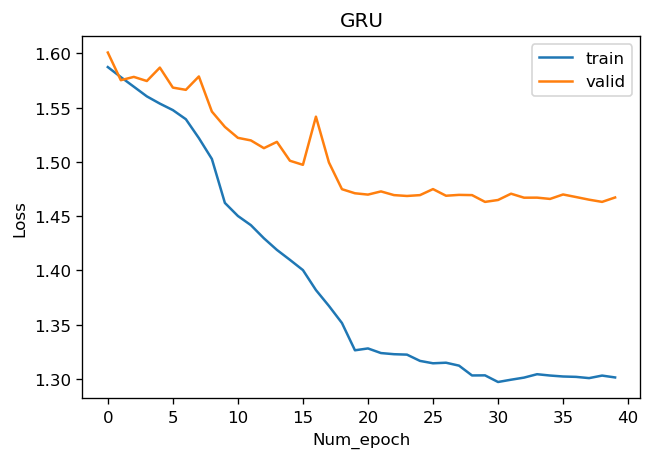

In [13]:
train_loss, valid_loss = train(model_gru, train_data, valid_data, epochs, lr, wd, lr_period, 
                               lr_decay, epoch_period, clipping_norm, batch_size, max_length, pre_embeding, ctx)
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['train','valid'])
plt.xlabel('Num_epoch')
plt.ylabel('Loss')
plt.title('GRU')

In [16]:
model_name = model_names[1]

embed_dim = 300
hidden_dim = 100
num_layers = 1
num_outputs = 5
dropout_rate = 0.5
#  model parameters

lr = 0.03
clipping_norm = 10
epochs = 40
wd = 5e-4
lr_period = 10
lr_decay = 0.1
epoch_period = 10
# optimization parameters

model_lstm = RNNModel(model_name, vocab_size, num_outputs, max_length, embed_dim, hidden_dim,
                       num_layers, dropout_rate)
model_lstm.collect_params().initialize(mx.init.Xavier(), ctx=context)

start
Epoch 1. Train Loss: 1.577123, Valid Loss: 1.578848, Train acc 0.269078, Valid acc 0.255515, Time 00:00:19, lr 0.03
Epoch 10. Train Loss: 1.513663, Valid Loss: 1.554463, Train acc 0.326545, Valid acc 0.285846, Time 00:00:19, lr 0.003
Epoch 20. Train Loss: 1.479383, Valid Loss: 1.540397, Train acc 0.347027, Valid acc 0.291360, Time 00:00:20, lr 0.00030000000000000003
Epoch 30. Train Loss: 1.475247, Valid Loss: 1.529886, Train acc 0.351709, Valid acc 0.302390, Time 00:00:20, lr 3.0000000000000004e-05
Epoch 39. Train Loss: 1.472423, Valid Loss: 1.535784, Train acc 0.349836, Valid acc 0.295956, Time 00:00:23, lr 3.0000000000000004e-05
Epoch 40. Train Loss: 1.473976, Valid Loss: 1.535529, Train acc 0.351358, Valid acc 0.297794, Time 00:00:22, lr 3.0000000000000005e-06


Text(0.5,1,'LSTM')

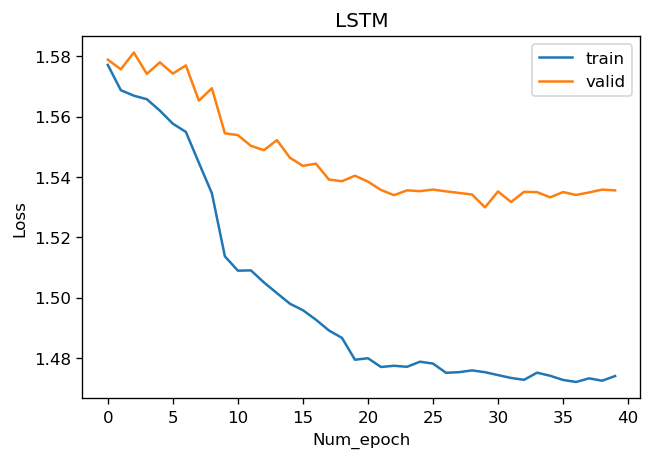

In [17]:
train_loss, valid_loss = train(model_lstm, train_data, valid_data, epochs, lr, wd, lr_period, 
                               lr_decay, epoch_period, clipping_norm, batch_size, max_length, pre_embeding, ctx)
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['train','valid'])
plt.xlabel('Num_epoch')
plt.ylabel('Loss')
plt.title('LSTM')

In [18]:
model_name = model_names[2]

embed_dim = 300
hidden_dim = 100
num_layers = 1
num_outputs = 5
dropout_rate = 0.5
#  model parameters

lr = 0.02
clipping_norm = 10
epochs = 40
wd = 5e-4
lr_period = 10
lr_decay = 0.1
epoch_period = 10
# optimization parameters

model_rnn_relu = RNNModel(model_name, vocab_size, num_outputs, max_length, embed_dim, hidden_dim,
                       num_layers, dropout_rate)
model_rnn_relu.collect_params().initialize(mx.init.Xavier(), ctx=context)

start
Epoch 1. Train Loss: 1.579088, Valid Loss: 1.576221, Train acc 0.266035, Valid acc 0.260110, Time 00:00:10, lr 0.02
Epoch 10. Train Loss: 1.479883, Valid Loss: 1.557112, Train acc 0.354635, Valid acc 0.285846, Time 00:00:10, lr 0.002
Epoch 20. Train Loss: 1.393001, Valid Loss: 1.543207, Train acc 0.405080, Valid acc 0.309743, Time 00:00:09, lr 0.0002
Epoch 30. Train Loss: 1.377101, Valid Loss: 1.539749, Train acc 0.409176, Valid acc 0.313419, Time 00:00:10, lr 2e-05
Epoch 39. Train Loss: 1.375118, Valid Loss: 1.541683, Train acc 0.409059, Valid acc 0.312500, Time 00:00:10, lr 2e-05
Epoch 40. Train Loss: 1.374893, Valid Loss: 1.541336, Train acc 0.409293, Valid acc 0.311581, Time 00:00:11, lr 2.0000000000000003e-06


Text(0.5,1,'RNN_Relu')

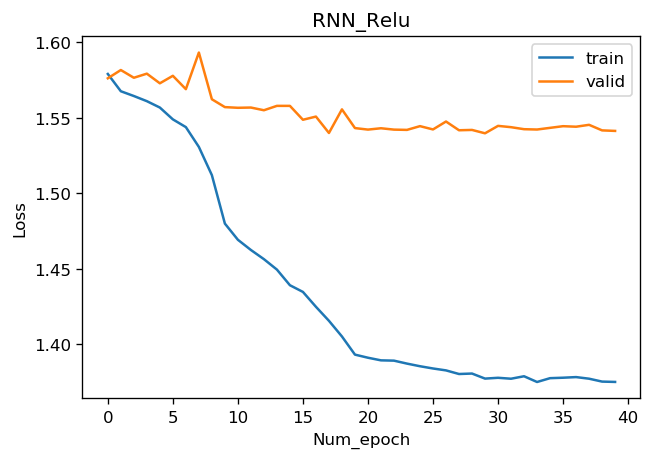

In [19]:
train_loss, valid_loss = train(model_rnn_relu, train_data, valid_data, epochs, lr, wd, lr_period, 
                               lr_decay, epoch_period, clipping_norm, batch_size, max_length, pre_embeding, ctx)
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['train','valid'])
plt.xlabel('Num_epoch')
plt.ylabel('Loss')
plt.title('RNN_Relu')

In [27]:
hidden = model_gru.begin_state(func = mx.nd.zeros, batch_size = batch_size)
test_accuracy_gru, _ = utils.evaluate_rnn(softmax_cross_entropy, test_data, model_gru, hidden, ctx)
print("The test accuracy of gru is %f" %(test_accuracy_gru))

hidden = model_lstm.begin_state(func = mx.nd.zeros, batch_size = batch_size)
test_accuracy_lstm, _ = utils.evaluate_rnn(softmax_cross_entropy, test_data, model_lstm, hidden, ctx)
print("The test accuracy of lstm is %f" %(test_accuracy_lstm))

hidden = model_rnn_relu.begin_state(func = mx.nd.zeros, batch_size = batch_size)
test_accuracy_rnn_relu, _ = utils.evaluate_rnn(softmax_cross_entropy, test_data, model_rnn_relu, hidden, ctx)
print("The test accuracy of RNN_Relu is %f" %(test_accuracy_rnn_relu))

The test accuracy of gru is 0.359149
The test accuracy of lstm is 0.320199
The test accuracy of lstm is 0.318388
